In [103]:
import torch
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

In [104]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
trainData = datasets.MNIST('data', transform=ToTensor(), download=True)
testData = datasets.MNIST('data', False, ToTensor())
trainDL = DataLoader(trainData, 10, True)
testDL = DataLoader(testData, 10)
# in channels (1 image in), out channels (6 filters out), kernel size (3x3 kernel), stride length (stride 1 each time)
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)
X, y = next(iter(trainData))
# 1 image, 28x28 size, is the number 5
X.shape, y

(torch.Size([1, 28, 28]), 5)

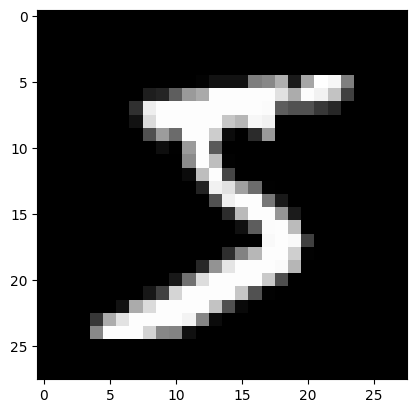

In [105]:
import matplotlib.pyplot as plt
plt.imshow(X.squeeze(), cmap='gray')

In [106]:
from torch.nn import functional as f
# just adding a layer and then passing through conv layer and relu
X = f.relu(conv1(X.view(1, 1, 28, 28)))
# 1 image, 6 different filters of it, images are now 26x26
X.shape

torch.Size([1, 6, 26, 26])

In [107]:
X = f.max_pool2d(X, 2, 2) # kernel 2, stride 2
X.shape

torch.Size([1, 6, 13, 13])

In [108]:
X = f.relu(conv2(X))
# we didn't add padding so we lose some pixels
X.shape

torch.Size([1, 16, 11, 11])

In [109]:
X = f.max_pool2d(X, 2, 2)
X.shape
# convolution --> pooling --> convolution --> pooling
# ((28-2)/2-2)/2 = 5.5 --> 5

torch.Size([1, 16, 5, 5])

In [110]:
class ConvNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        # can't use sequential
        self.conv1 = conv1
        self.conv2 = conv2
        # fully connected layers
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = f.relu(self.conv1(x))
        x = f.max_pool2d(x, 2, 2)
        x = f.relu(self.conv2(x))
        x = f.max_pool2d(x, 2, 2)
        x = x.view(-1, 5 * 5 * 16) # -1 --> allows varying first dimension (batch size, number of images)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        # similar to sigmoid function
        return f.log_softmax(x, 1)

In [111]:
# torch.manual_seed(1)
model = ConvNetModel()
model

ConvNetModel(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [112]:
lossFun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # smaller lr means it takes longer
epochs = 5
trainLosses = []
testLosses= []
trainCorrect = []
testCorrect = []
loss = 0
for epoch in range(epochs):
    trainCorCount = 0
    testCorCount = 0
    
    for batchCounter, (XTrain, yTrain) in enumerate(trainDL):
        yPred = model(XTrain)
        loss = lossFun(yPred, yTrain)
        
        pred = torch.max(yPred.data, 1)[1]

        # noinspection PyUnresolvedReferences
        trainCorCount += (pred == yTrain).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batchCounter % 600 == 0:
            print(f'{epoch=}, {batchCounter=}, {loss.item()=:.4f}')
            
    trainLosses.append(loss)
    trainCorrect.append(trainCorCount)
    
    with torch.no_grad():
        for batchCounter, (XTest, yTest) in enumerate(trainDL):
            y = model(XTest)
            pred = torch.max(y.data, 1)[1]
            # noinspection PyUnresolvedReferences
            testCorCount += (pred == y).sum()
            
    loss = lossFun(y, yTest)
    
    testLosses.append(loss)
    testCorrect.append(testCorCount)
    
    print(f'\n{epoch=}, {testCorCount=}\n')

epoch=0, batchCounter=0, loss.item()=2.3067
epoch=0, batchCounter=600, loss.item()=0.1945
epoch=0, batchCounter=1200, loss.item()=0.0427
epoch=0, batchCounter=1800, loss.item()=0.1222
epoch=0, batchCounter=2400, loss.item()=0.0744
epoch=0, batchCounter=3000, loss.item()=0.2376
epoch=0, batchCounter=3600, loss.item()=0.0042
epoch=0, batchCounter=4200, loss.item()=0.0103
epoch=0, batchCounter=4800, loss.item()=0.0032
epoch=0, batchCounter=5400, loss.item()=0.0017

epoch=0, testCorCount=tensor(0)

epoch=1, batchCounter=0, loss.item()=0.0259
epoch=1, batchCounter=600, loss.item()=0.0208
epoch=1, batchCounter=1200, loss.item()=0.0040
epoch=1, batchCounter=1800, loss.item()=0.0005
epoch=1, batchCounter=2400, loss.item()=0.0172
epoch=1, batchCounter=3000, loss.item()=0.0590
epoch=1, batchCounter=3600, loss.item()=0.0098
epoch=1, batchCounter=4200, loss.item()=0.0019
epoch=1, batchCounter=4800, loss.item()=0.0098
epoch=1, batchCounter=5400, loss.item()=0.0012

epoch=1, testCorCount=tensor(55)
